In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

%matplotlib inline
%load_ext google.cloud.bigquery

In [2]:
from google.cloud import bigquery
import glob

credential_path = glob.glob(r'../../BQ_Keypath/*.json')
client = bigquery.Client.from_service_account_json(credential_path[0])

# define helper functions
def getQueryAsDF(query):
    return client.query(query).result().to_dataframe()

def getTableSchema(table):
    return client.get_table(table).schema

## 1. Population Growth Over Time
We will be looking at users signup rate year by year. This will give us insight for the platform growth. 

In [3]:
# understanding users table's schema
schema = getTableSchema('bigquery-public-data.stackoverflow.users')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('about_me', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('age', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_access_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('location', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('reputation', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('up_votes', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('down_votes', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('views', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('profile_image_url', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('website_url', 'STRING', 'NULLABLE', None, (), None)]

In [4]:
# since all field are NULLABLE modes, checking for nulls 
query = """
            SELECT 
                COUNT(*) AS null_count
            FROM
                `bigquery-public-data.stackoverflow.users`
            WHERE
                id IS NULL
                OR creation_date IS NULL
                OR last_access_date IS NULL;
        """

result = getQueryAsDF(query)
result

,null_count
0,0


In [5]:
# user signup count by year
query = """
            SELECT 
                EXTRACT (YEAR FROM creation_date) AS year,
                COUNT(DISTINCT id) AS signup_count
            FROM `bigquery-public-data.stackoverflow.users`
            WHERE
                DATE(creation_date) BETWEEN '2008-09-15' AND CURRENT_DATE() -- 09/15/08 is the platform launch date. 
            GROUP BY 1
            ORDER BY 1
        """

result = getQueryAsDF(query)
result

,year,signup_count
0,2008,17319
1,2009,78007
2,2010,199205
3,2011,358720
4,2012,678857
5,2013,1122387
6,2014,1174726
7,2015,1252388
8,2016,1515482
9,2017,1726646


In [6]:
# looking at user signup trend yearly.
users_count = result['signup_count'].values
total_user_count = result['signup_count'].sum()
cumulative_perc = []
cummulative_count = []
cumulative_perc.append(round(users_count[0]/total_user_count * 100, 2))
cummulative_count.append(users_count[0])

for i in range(len(users_count)):
    index = i+2
    if index <= len(users_count):
        curr_count = np.sum(users_count[:index])
        cummulative_count.append(curr_count)
        cumulative_perc.append(round(curr_count/total_user_count * 100, 2))
        
df = result
df['cumulative_perc'] = cumulative_perc
df['cumulative_count'] = cummulative_count
df

,year,signup_count,cumulative_perc,cumulative_count
0,2008,17319,0.11,17319
1,2009,78007,0.61,95326
2,2010,199205,1.90,294531
3,2011,358720,4.21,653251
4,2012,678857,8.58,1332108
5,2013,1122387,15.80,2454495
6,2014,1174726,23.36,3629221
7,2015,1252388,31.42,4881609
8,2016,1515482,41.18,6397091
9,2017,1726646,52.29,8123737


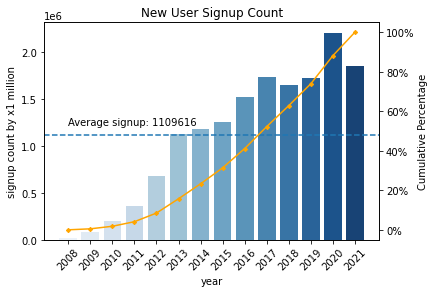

In [21]:
fig, ax = plt.subplots();

ax = sns.barplot(data = df, x = 'year', y = 'signup_count', palette = 'Blues')

avg_growth_count = np.average(df['signup_count'])
text_avg_growth_count = 'Average signup: {}'.format(round(avg_growth_count))
plt.axhline(avg_growth_count, ls = '--')
plt.text(0, avg_growth_count * 1.1, text_avg_growth_count)
plt.xticks(rotation = 45)
plt.ylabel('signup count by x1 million')

ax2 = ax.twinx()
ax2.plot(df.index, df['cumulative_perc'], color = 'orange', marker="D", ms=3)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage");

plt.title('New User Signup Count')

Population growth for the platform is growing year after year with an average of 1109925 new users signed up. We can see the spurred starting from 2013. 

However, raw population growth metric does not tell us much about the platform overal performance. DAU, MAU and users retention will give us more insight.

## 3. MAU and DAU 
- understanding platform monthly retention rate over time.

In [8]:
# looking into comments, question and answer tables schema
schema = getTableSchema('bigquery-public-data.stackoverflow.posts_questions')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('title', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('body', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('accepted_answer_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('answer_count', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('favorite_count', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, (), None),
 Sch

In [9]:
schema = getTableSchema('bigquery-public-data.stackoverflow.posts_answers')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('title', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('body', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('accepted_answer_id', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('answer_count', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('favorite_count', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, (), None),
 Schema

In [10]:
schema = getTableSchema('bigquery-public-data.stackoverflow.comments')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('text', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('post_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('user_display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('score', 'INTEGER', 'NULLABLE', None, (), None)]

Can safely assume the creation_date field for each of the table has non-null values.

In [11]:
from google.cloud.exceptions import NotFound

# combining tables into a view for quick access later.
view_id = "portfolio-331917.stored_views.active_users"

try:
    client.get_table(view_id)
    print('view already exist, skipping')
except NotFound:
    view = bigquery.Table(view_id)
    view.view_query = f"""
                        SELECT
                            creation_date,
                            EXTRACT (YEAR FROM creation_date) AS year,
                            EXTRACT (MONTH FROM creation_date) AS month,
                            owner_user_id
                        FROM `bigquery-public-data.stackoverflow.posts_questions`
                        WHERE
                            NOT owner_user_id IS NULL 
                        UNION ALL 
                        SELECT
                            creation_date,
                            EXTRACT (YEAR FROM creation_date) AS year,
                            EXTRACT (MONTH FROM creation_date) AS month,
                            owner_user_id
                        FROM `bigquery-public-data.stackoverflow.posts_answers`
                        WHERE
                            NOT owner_user_id IS NULL 
                        UNION ALL 
                        SELECT
                            creation_date,
                            EXTRACT (YEAR FROM creation_date) AS year,
                            EXTRACT (MONTH FROM creation_date) AS month,
                            user_id AS owner_user_id
                        FROM `bigquery-public-data.stackoverflow.comments`
                        WHERE
                            NOT user_id IS NULL 
                        """
    view = client.create_table(view)

view already exist, skipping


In [12]:
# quick null checking to ensure the table is null free
query = """
        SELECT 
            *
        FROM `portfolio-331917.stored_views.active_users`
        WHERE 
            creation_date IS NULL 
            OR year IS NULL 
            OR month IS NULL 
            OR owner_user_id IS NULL 
        """

result = getQueryAsDF(query)
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   creation_date  0 non-null      datetime64[ns, UTC]
 1   year           0 non-null      int64              
 2   month          0 non-null      int64              
 3   owner_user_id  0 non-null      int64              
dtypes: datetime64[ns, UTC](1), int64(3)
memory usage: 124.0 bytes


great, none of the fields have any null value and they are assigned to appropriate data typed. 

In [13]:
# grabbing mau and dau from the saved view
# cte for readability of the sql
query = """
        WITH dau AS
        (
            SELECT 
                DISTINCT DATE(creation_date) AS date,
                year, month,
                COUNT(DISTINCT owner_user_id) AS dau
            FROM `portfolio-331917.stored_views.active_users`
            GROUP BY 1,2,3
            ORDER BY 1
        ),

        mau AS
        (
            SELECT 
                year, month,
                COUNT(DISTINCT owner_user_id) AS mau
            FROM `portfolio-331917.stored_views.active_users`
            GROUP BY 1,2
            ORDER BY 1,2
        )

        SELECT 
            date,
            dau.year,
            dau.month,
            dau.dau,
            mau.mau,
            (dau.dau/mau.mau * 100) AS ratio
        FROM 
            dau JOIN 
            mau ON dau.year = mau.year AND dau.month = mau.month
        """

df_dau_mau = getQueryAsDF(query)
df_dau_mau.sample(10)

,date,year,month,dau,mau,ratio
1627,2017-03-24,2017,3,18319,221388,8.274613
3923,2013-06-21,2013,6,14727,145821,10.099368
2964,2016-03-08,2016,3,19747,210024,9.402259
2993,2017-08-17,2017,8,18299,202391,9.041410
1600,2016-05-28,2016,5,8888,201052,4.420747
1532,2017-10-03,2017,10,16787,198473,8.458077
1533,2017-10-06,2017,10,16248,198473,8.186504
4210,2013-05-25,2013,5,7487,151428,4.944264
1130,2019-12-04,2019,12,16584,171271,9.682900
3609,2015-03-07,2015,3,9440,194295,4.858591


In [14]:
df_dau_mau.describe()

,year,month,dau,mau,ratio
count,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000
mean,2014.628631,6.535423,11337.849530,142440.589969,8.738489
std,3.801598,3.438611,5624.145954,65964.667566,3.421602
min,2008.000000,1.000000,3.000000,3.000000,2.194211
25%,2011.000000,4.000000,7343.000000,84920.000000,6.158495
50%,2015.000000,7.000000,11934.000000,175127.000000,8.786930
75%,2018.000000,9.000000,16405.000000,192130.000000,10.466024
max,2021.000000,12.000000,20831.000000,221388.000000,100.000000


We can estimate the population mean of the dau/mau ratio is ~8.74%. That is quite low for the platform "stickiness" comparing to industry standard of 20%.

With a little help from the scipy library, we can determine the 95% CI for the true population mean of the dau/mau ratio.

In [15]:
import scipy.stats as st

ratio = df_dau_mau["ratio"].values
confi_lvl = .95
ratio_mean = np.mean(ratio)
std_err_mean = st.sem(ratio) 

# note: using the st.norm instead of st.t due to the dataset size. With CLT, we can assume the dataset is normally distr. 
ratio_ci = st.norm.interval(alpha = confi_lvl, loc = ratio_mean, scale = std_err_mean)
ratio_ci

(8.641541088311481, 8.835436111465818)

From the result, there is a 5% chance of the population mean of dau/mau ratio below ~8.64% or above ~8.83%.

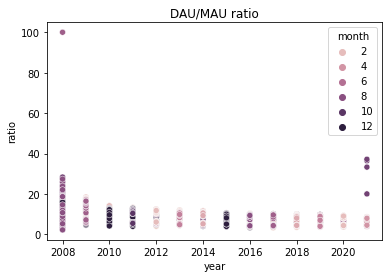

In [22]:
# checking for outliers
sns.scatterplot(data = df_dau_mau, x = 'year', y = 'ratio', hue = 'month')
plt.title('DAU/MAU ratio')

There is 1 data point with 100% dau/mau ratio. This fell on the date of 2008-07-31, 1 and a half month before the platform publicly launch. There were 3 users for both dau and mau for that date. 

I decided to included this data point since it was interesting to see the dataset goes back prelaunch date(2008-09-15). More importantly, it does not impact the estimated population mean or the CI enough to make a difference. 

For more insight, we can dive into cohort analysis to understand the retention rate in another project. 

## 3. Popular Topic Trending
- top 10 most popular topics by question posts of all time.
- Trending by month

In [24]:
query = """
        SELECT 
            tags,
            COUNT(*) AS total_posts
        FROM 
            (
                SELECT 
                    SPLIT(tags, '|') AS tags
                FROM `bigquery-public-data.stackoverflow.posts_questions`
            ), UNNEST(tags) AS tags
        GROUP BY 1
        ORDER BY 2 DESC
        LIMIT 10
        """

result = getQueryAsDF(query)
result

,tags,total_posts
0,javascript,2265418
1,java,1796493
2,python,1788579
3,c#,1495812
4,php,1413361
5,android,1346916
6,html,1088648
7,jquery,1016899
8,c++,736106
9,css,730652


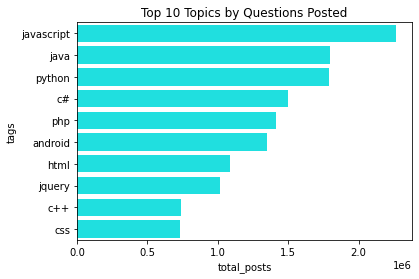

In [25]:
sns.barplot(data = result, x = 'total_posts', y = 'tags', color = 'cyan')
plt.title("Top 10 Topics by Questions Posted")

Javascript takes the top spot for the all time favorite and the most asked topic on the platform. Not surprising since Javascript shines on both client-side and server-side for web development. With the top 10 included Javascript, html, php and css, my assumption is many of the users on the platform are web developers. Would be an interesting hypothesis to test on a difference project.

Java and Python are closely tied up for 2nd and 3rd place. 

What about 2021? Specially, what is the top topic, each month, asked by question posts?

In [26]:
# top 3 tags/topics by questions asked. 
query = """
        -- tally up questions asked by the month and topic
        WITH all_tags AS
        (
            SELECT 
                EXTRACT(MONTH FROM creation_date) AS month,
                tags,
                COUNT(*) AS total
            FROM 
            (
                SELECT
                    creation_date, 
                    SPLIT(tags, '|') AS tag
                FROM `bigquery-public-data.stackoverflow.posts_questions`
            ), UNNEST(tag) AS tags
            WHERE 
                EXTRACT(YEAR FROM creation_date) = 2021
            GROUP BY 1,2
        )

        SELECT 
            *
        FROM 
        (
            -- give rank to tally by total tags 
            SELECT 
                *,
                RANK() OVER(PARTITION BY month ORDER BY total DESC) AS rank
            FROM all_tags
            ORDER BY 3 DESC
        )
        WHERE 
            rank BETWEEN 1 and 3
            AND month < 9 -- exclude September since data for the month are missing/incomplete
        ORDER BY 1,4
        """

result = getQueryAsDF(query)
result

,month,tags,total,rank
0,1,python,26415,1
1,1,javascript,19584,2
2,1,java,9579,3
3,2,python,25016,1
4,2,javascript,17992,2
5,2,java,9178,3
6,3,python,28209,1
7,3,javascript,19844,2
8,3,java,10451,3
9,4,python,26574,1


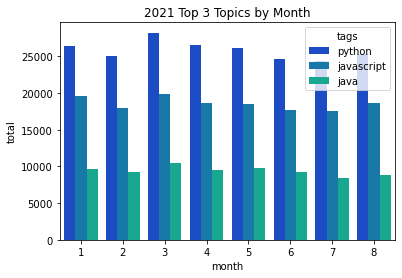

In [27]:
sns.barplot(data = result, y = 'total', x = 'month', hue = 'tags', palette = 'winter')
plt.title("2021 Top 3 Topics by Month")

This is quite surprising. Python dominated every single month in 2021, from January to August. Dataset indicates Python began to overtake Javascript in early 2019 and continuing into 2021.